In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bz2 #can handle .bz2 compressed files

# Exercise 1

## Problem statement
*Count the number of lines in Python for each file.*

## Solution

**Issues**

* Looking at the naming of the archives: .csv.bz2, I saw that this was a compressed file. So that, at first I tried to decompress it in order to read the csv. This was producing files about 5 Gbs. So that, I thought that this was not the best approach, and that it was better trying to work directly with the .bz2 if possible.

* After looking the documentation of pandas.read_csv I discovered that it could open these files directly. During this research I also found out the package bz2 and that it allowed me to open the compress file directly.

* First, I tried the *straight-forward* approach, opening the file and then using some function to give me the number of lines... This was not working because the files are too large for my computer.



In [12]:
#Filenames declaration
fsearches='../data/Challenge/searches.csv.bz2'
fbookings='../data/Challenge/bookings.csv.bz2'

In [10]:
# Read the file line by line and count
count=0
with bz2.BZ2File(fsearches,"r") as file:
    for line in file:
        count +=1
print(count)
nlines_searches = count
# Read the file line by line and count
count=0
with bz2.BZ2File(fbookings,"r") as file:
    for line in file:
        count +=1
print(count)
nlines_bookings=count

KeyboardInterrupt: 

In [7]:
print "File %s has %s lines."%(fsearches,nlines_searches)
print "File %s has %s lines."%(fbookings,nlines_bookings)

File searches.csv.bz2 has 20390199 lines.
File bookings.csv.bz2 has 10000011 lines.


# Exercise 2

## Problem statement

*top 10 arrival airports in the world in 2013 (using the bookings file)*

Arrival airport is the column arr_port. It is the IATA code for the airport

To get the total number of passengers for an airport, you can sum the column pax, grouping by arr_port. Note that there is negative pax. That corresponds to cancelations. So to get the total number of passengers that have actually booked, you should sum including the negatives (that will remove the canceled bookings).

Print the top 10 arrival airports in the standard output, including the number of passengers.

Bonus point: Get the name of the city or airport corresponding to that airport (programatically, we suggest to have a look at GeoBases in Github)

Bonus point: Solve this problem using pandas (instead of any other approach)

## Solution

**Issues and comments**

* When opening the file without specifying "sep" flag, the labels had strange characters '^' on them (or I had weird dataframe shapes). These characters were the actual separators (tabs).

* Thinking about how to work with chunks instead of reading the dataframe at once, took most of my time of this problem. After some research I decided that my favorite way to proceed was using .append command in order to write a file with the desired part of the chunks I was using.

* Because I was expecting to make quite a lot of "trial and errors" I thought that this approach would save me a lot of time. This would separate the workflow in two:
    * 1) Extracting the relevant data to an easy-to-read/easy-to-access file (*ffilter*).
    * 2) Performing the operations on the data. Taking the data directly from this second file (*ffilter*).

### 1) Accessing data efficiently

Prepare dataframe to be read using chunks (due to RAM restrictions). Note that the columns are separated by '^' character in the Bookings file.

We will define two different chunksizes:

    * chksize_big: for production
    * chksize_small: for testing and overview.
    
Read column labels and sample (first chunk) to overview data.

In [14]:
chksize_big=1000000 #used for production
chksize_small = 1000 #used for testing
reader = pd.read_csv(fbookings,compression='bz2', sep='^',iterator=True, chunksize=chksize_small)
#Get some relevant information about the dataframe
for df in reader:
    [rows,cols] = df.shape
    bookings_labels = df.columns
    bookings_head   = df.head()
    bookings_tail   = df.tail()
    break
#Show sample
print(bookings_head)
print(bookings_tail)

   act_date             source  pos_ctry                          pos_iata  \
0  2013-03-05 00:00:00  1A      DE        a68dd7ae953c8acfb187a1af2dcbe123   
1  2013-03-26 00:00:00  1A      US        e612b9eeeee6f17f42d9b0d3b79e75ca   
2  2013-03-26 00:00:00  1A      US        e612b9eeeee6f17f42d9b0d3b79e75ca   
3  2013-03-26 00:00:00  1A      AU        0f984b3bb6bd06661c95529bbd6193bc   
4  2013-03-26 00:00:00  1A      AU        0f984b3bb6bd06661c95529bbd6193bc   

                          pos_oid                      rloc            \
0  1a11ae49fcbf545fd2afc1a24d88d2b7  ea65900e72d71f4626378e2ebd298267   
1  7437560d8f276d6d05eeb806d9e7edee  737295a86982c941f1c2da9a46a14043   
2  7437560d8f276d6d05eeb806d9e7edee  737295a86982c941f1c2da9a46a14043   
3  36472c6dbaf7afec9136ac40364e2794  5ecf00fdcbcec761c43dc7285253d0c1   
4  36472c6dbaf7afec9136ac40364e2794  5ecf00fdcbcec761c43dc7285253d0c1   

   cre_date             duration  distance  dep_port    ...      \
0  2013-02-22 00:00:00   

In [15]:
print(bookings_labels)

Index(['act_date           ', 'source', 'pos_ctry', 'pos_iata', 'pos_oid  ',
       'rloc          ', 'cre_date           ', 'duration', 'distance',
       'dep_port', 'dep_city', 'dep_ctry', 'arr_port', 'arr_city', 'arr_ctry',
       'lst_port', 'lst_city', 'lst_ctry', 'brd_port', 'brd_city', 'brd_ctry',
       'off_port', 'off_city', 'off_ctry', 'mkt_port', 'mkt_city', 'mkt_ctry',
       'intl', 'route          ', 'carrier', 'bkg_class', 'cab_class',
       'brd_time           ', 'off_time           ', 'pax', 'year', 'month',
       'oid      '],
      dtype='object')


### 2) Filtering dataframe

Reading the dataframe in chunks, we will append the target columns on a new dataframe (written as hdf5 file called **'ex2.h5'**). 
We need to pay special attention to missing values. In this case we have found some 'Na' value on PAX, this giving errors when trying to append the data.

In [7]:
#Filename to write the filtered results
ffilter = 'ex2.h5'

In [8]:
#In order to handle numerica NaN values on PAX, we will set missing values to 0.
def nan2zero(num):
    try:
        return np.int(num)
    except:
        return 0

reader = pd.read_csv(fbookings,compression='bz2', sep='^',iterator=True,memory_map=True, \
                     chunksize=chksize_big,converters={'pax':nan2zero},low_memory=False)
with pd.HDFStore(ffilter,mode='w') as store:
    nc = 1
    for df in reader:
        print "Reading chunk number %s"%nc
        #Reduce the problem to two columns
        df2            = df.filter(['arr_port','pax'],axis=1)
        df2['pax']     = df2['pax'].astype(int)
        df2['arr_port']= df2['arr_port'].astype('str').str.strip().str.upper()
        #Write to file
        store.append('bookings', df2)#data_columns=['arr_port','pax'])
        nc += 1

Reading chunk number 1
Reading chunk number 2
Reading chunk number 3
Reading chunk number 4
Reading chunk number 5
Reading chunk number 6
Reading chunk number 7
Reading chunk number 8
Reading chunk number 9
Reading chunk number 10
Reading chunk number 11


//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (7,8,27) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Now, the problem has been reduced to a dataframe with only 2 columns (instead of 38) with a size <300 Mb.

### 3) Find top 10 airports by pax numbers.

In [9]:
#Read the filtered file and check dataframe
df = pd.read_hdf(ffilter,mode='r')
df.tail(10)

,arr_port,pax
10000000,MEL,2
10000001,LAS,2
10000002,LAS,2
10000003,MAA,1
10000004,MAA,1
10000005,MAA,-1
10000006,MAA,1
10000007,RDU,1
10000008,ORY,1
10000009,ORY,1


** We are assuming that all the information provided in arr_port and pax is correct. Moreover, we will eliminate now the airports with 'NaN', without trying to infer the value by inspection.**

First, we will make sure that IATA code is given by the 3 first characters without any space behind (trying to avoid possible duplicates).

In [10]:
df['arr_port']=df['arr_port'].str.strip()

Note that **there exists an airport with code NAN**, but all the IATA codes are given with Capital letters, 
so that, it is expected that the value 'NaN' is just a missing value.

In [11]:
mask = df['arr_port'].isin(['NaN', 'NA', ' '])
print df.shape
df = df[~mask]
print df.shape

(10000010, 2)
(10000010, 2)


No missing value has been found on the data.

Now, group by arr_port and sum the numbers on pax column

In [12]:
df2 = df.groupby(['arr_port']).sum()

In [13]:
print df2.head(5)
print df2.tail(5)

           pax
arr_port      
AAB         30
AAE        810
AAL        810
AAN         20
AAQ       1650
           pax
arr_port      
ZWE         30
ZWS        620
ZYL       1290
ZYN         20
ZYR       1020


Sort in descending order and show the **top 10 airports**:

In [14]:
df3=df2.sort_values('pax',ascending=False)
df3.head(10)

,pax
arr_port,
LHR,88809
MCO,70930
LAX,70530
LAS,69630
JFK,66270
CDG,64490
BKK,59460
MIA,58150
SFO,58000


### 4) Find the names of the cities using GeoBases

First, we need to clone and follow the instructions for installation of GeoBases. Once it is installed, we can use it in order to give the name of the city for a given Airport code.

In [15]:
from GeoBases import GeoBase
geo_o = GeoBase(data='ori_por', verbose=False)
#geo_a = GeoBase(data='airports', verbose=False)

In [16]:
#Testing geobases with an example
geo_o.get('LHR','city_name_ascii')

'London'

Take the previous dataframe with the top 10 airports and convert it to lists.

In [17]:
top10 = df3.head(10)
top10 = top10.reset_index(level=['arr_port']) #Reset index in order to use arr_port as a column again
top10_names = top10['arr_port'].tolist()
top10_pax = top10['pax'].tolist()
print top10_names

['LHR', 'MCO', 'LAX', 'LAS', 'JFK', 'CDG', 'BKK', 'MIA', 'SFO', 'DXB']


In [18]:
# Print results nicely
print "Top 10 ranking airports/cities"
ipos = 1
for IATA in top10_names:
    city = geo_o.get(IATA,'city_name_ascii')
    pax = top10_pax[ipos-1]
    print "%s) %s, city: %s --> %s pax"%(ipos,IATA,city,pax)
    ipos += 1

Top 10 ranking airports/cities
1) LHR, city: London --> 88809 pax
2) MCO, city: Orlando --> 70930 pax
3) LAX, city: Los Angeles --> 70530 pax
4) LAS, city: Las Vegas --> 69630 pax
5) JFK, city: New York City --> 66270 pax
6) CDG, city: Paris --> 64490 pax
7) BKK, city: Bangkok --> 59460 pax
8) MIA, city: Miami --> 58150 pax
9) SFO, city: San Francisco --> 58000 pax
10) DXB, city: Dubai --> 55590 pax


### 5) Sanity check

After all the data manipulation it is importat to check if the results make sense.

First of all we see that the top 10 airports are indeed important hubs or big cities. In addition, the pax numbers are also reasonable. We can also see that Geobase package is working well; for instance: LHR, LAX and JFK are some well-known aiports.

# Exercise 3

## Problem statement

*plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona*

For the arriving airport, you can use the Destination column in the searches file. Plot a curve for Málaga, another one for Madrid, and another one for Barcelona, in the same figure.

Bonus point: Solving this problem using pandas (instead of any other approach)

## Solution

### 1) Overview data on 'searches' file

In [19]:
fsearches = 'searches.csv.bz2'
chksize_big=1000000 #used for production
chksize_small = 10000 #used for testing
reader = pd.read_csv(fsearches,compression='bz2', sep='^',iterator=True, chunksize=chksize_small)
#Get some relevant information about the dataframe
ichunk = 1
for df in reader:
    [rows,cols] = df.shape
    searches_labels = df.columns
    searches_head   = df.head(2)
    searches_tail   = df.tail(2)
#Show sample
    print searches_head
    print searches_tail
    ichunk +=1
    if ichunk>20:
        break
    

         Date      Time TxnCode                          OfficeID Country  \
0  2013-01-01  20:25:57     MPT  624d8c3ac0b3a7ca03e3c167e0f48327      DE   
1  2013-01-01  10:15:33     MPT  b0af35b31588dc4ab06d5cf2986e8e02      MD   

  Origin Destination  RoundTrip  NbSegments Seg1Departure      ...        \
0    TXL         AUH          1           2           TXL      ...         
1    ATH         MIL          0           1           ATH      ...         

  Seg6Arrival Seg6Date Seg6Carrier Seg6BookingCode    From IsPublishedForNeg  \
0         NaN      NaN         NaN             NaN  1ASIWS                 0   
1         NaN      NaN         NaN             NaN  1ASIWS                 0   

  IsFromInternet IsFromVista                        TerminalID InternetOffice  
0              0           0  d41d8cd98f00b204e9800998ecf8427e            FRA  
1              0           0  d41d8cd98f00b204e9800998ecf8427e            KIV  

[2 rows x 45 columns]
            Date      Time TxnCode 

In [20]:
print searches_labels.tolist()

['Date', 'Time', 'TxnCode', 'OfficeID', 'Country', 'Origin', 'Destination', 'RoundTrip', 'NbSegments', 'Seg1Departure', 'Seg1Arrival', 'Seg1Date', 'Seg1Carrier', 'Seg1BookingCode', 'Seg2Departure', 'Seg2Arrival', 'Seg2Date', 'Seg2Carrier', 'Seg2BookingCode', 'Seg3Departure', 'Seg3Arrival', 'Seg3Date', 'Seg3Carrier', 'Seg3BookingCode', 'Seg4Departure', 'Seg4Arrival', 'Seg4Date', 'Seg4Carrier', 'Seg4BookingCode', 'Seg5Departure', 'Seg5Arrival', 'Seg5Date', 'Seg5Carrier', 'Seg5BookingCode', 'Seg6Departure', 'Seg6Arrival', 'Seg6Date', 'Seg6Carrier', 'Seg6BookingCode', 'From', 'IsPublishedForNeg', 'IsFromInternet', 'IsFromVista', 'TerminalID', 'InternetOffice']


We can see that, there is no label for "month". We have to extract month information from label 'Date'. A possible issue could be the different american format vs the european format for the date (yyyy-mm-dd vs yyyy-dd-mm). 

### 2) Filter dataframe and write to hdf5 file.

In this case, we are only intereseted in Destination and Date. We could even discard all airports different from 
the 3 we want to plot: MALAGA (AGP), MADRID (MAD) and BARCELONA (BCN).

**Issues**
* When using pd.to_datetime, we need to make sure about the format of the Date (yearfirst and then month).
* For missing values on pd.to_datetime it will raise and exception, we use flag errors='coerce' to write 'NaT' instead of stopping.
* Some missing values where creating problems, so that, we added .dorpna function in order to get rid of 'NaN' values prior writing them on h5 file.

In [21]:
chksize_big = 1000000
ffilter = 'ex3.h5'
#In order to handle numerica NaN values on PAX, we will set missing values to 0.
def nan2zero(num):
    try:
        return np.int(num)
    except:
        return 0

reader = pd.read_csv(fsearches,compression='bz2', sep='^',iterator=True,memory_map=True, \
                     chunksize=chksize_big)#,converters={'pax':nan2zero})
with pd.HDFStore(ffilter,mode='w') as store:
    nc = 1
    for df in reader:
        print "Reading chunk number %s"%nc
        #Reduce the problem to two columns
        df2            = df.filter(['Destination','Date'],axis=1)
        #Drop NaN values
        df2 = df2.dropna(axis=0,how='any')
        #Go to datetime format with pandas
        df2['Date'] = pd.to_datetime(df2['Date'],errors='coerce',yearfirst=True)
        df2['Month'] = df2['Date'].dt.month
        #Make sure string is clean (no white spaces)
        df2['Destination']= df2['Destination'].astype('str').str.strip().str.upper()
        #Write to file
        store.append('searches', df2)#data_columns=['arr_port','pax'])
        nc += 1

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (40,41,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Reading chunk number 1
Reading chunk number 2
Reading chunk number 3
Reading chunk number 4
Reading chunk number 5
Reading chunk number 6
Reading chunk number 7
Reading chunk number 8
Reading chunk number 9
Reading chunk number 10
Reading chunk number 11
Reading chunk number 12
Reading chunk number 13
Reading chunk number 14
Reading chunk number 15
Reading chunk number 16
Reading chunk number 17
Reading chunk number 18
Reading chunk number 19
Reading chunk number 20
Reading chunk number 21


//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (29,30,31,32,33,34,35,36,37,38,44) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### 3) Read the filtered DataFrame.

In [22]:
%matplotlib inline  

In [23]:
#Read the filtered file and check dataframe
df = pd.read_hdf(ffilter,mode='r')
df.tail(10)

,Destination,Date,Month
20390188,MCT,2013-10-13,10
20390189,SKG,2013-10-13,10
20390190,AMD,2013-10-13,10
20390191,BRS,2013-10-13,10
20390192,AKL,2013-10-13,10
20390193,NBO,2013-10-13,10
20390194,ALA,2013-10-13,10
20390195,LHR,2013-10-13,10
20390196,MAD,2013-10-13,10
20390197,HA,2013-10-13,10


### 4) Plot results using Pandas

*Note that before creating the following script, I tried to plot just one of the cases (DSTN='AGP') without any loop.
Once I understood how this was working I implemented the loop.*

* Malaga   = 'AGP'
* Madrid   = 'MAD'
* Barcelona = 'BCN'

Total searches for AGP over the year are = 97177
Total searches for MAD over the year are = 269143
Total searches for BCN over the year are = 310062


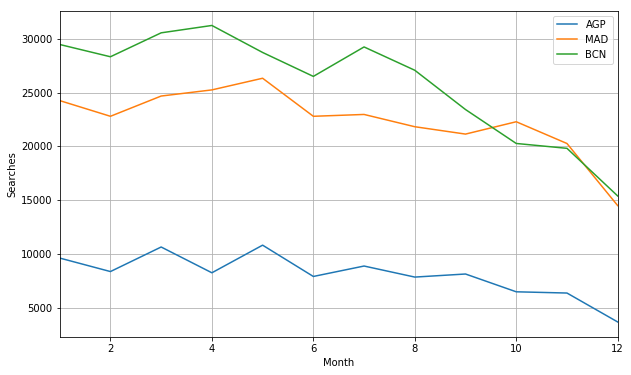

In [24]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
vDSTN = ['AGP','MAD','BCN']
for DSTN in vDSTN:
    survey = df[df['Destination'] == DSTN]
    df2 = survey.groupby(['Month']).count()
    df2 = df2.reset_index(level=['Month'])
    print "Total searches for %s over the year are = %s"%(DSTN,df2['Destination'].sum())
    df2.plot(x='Month',y='Destination',label=DSTN,ax=ax)
ax.set_ylabel('Searches')
plt.grid('on')

# Exercise 4

## Problem statement

*match searches with bookings*

For every search in the searches file, find out whether the search ended up in a booking or not (using the info in the bookings file). For instance, search and booking origin and destination should match. For the bookings file, origin and destination are the columns dep_port and arr_port, respectively. Generate a CSV file with the search data, and an additional field, containing 1 if the search ended up in a booking, and 0 otherwise.

Bonus point: Solving this problem using pandas (instead of any other approach)

## Solution

** Issues **

* When comparing dataframes using *merge* we were not finding any successful search. This was due to a problem with white spaces on Origin/Destiny entries. This problem is solved using command .str.strip().str.upper() on these fields.

### 1) Initial considerations

* In order to crosschek both files (bookings and searches) and check search by search, it is important to optimize the process avoiding time consuming operations.

* We need to make sure that bookings with same Origin and Destination do not count more than once when comparing them with searches.

* For Searches file, it is clear that the relevant Date is the field "Date" and it gives the date when the user was browsing looking for a flight.

* For Bookings there are 4 different dates: act_date, cre_date, brd_time and off_time. After some inspection and taking into account the typical aeronautical naming:
    * brd_time: boarding time.
    * off_time: take off time of the flight.
    * act_date: **activation date?**. Possibly but not sure.
    * cre_date: **creation date?**. Possibly but not sure.
* I pretend to take into account four things when checking if a search end up with a booking:
    * Origin: both of the entries need to have same origin.
    * Destination: both of the entries need to have same destination.
    * Date: If a search is done on January 1st from JFK to LAX and there is some booking on April 4th from JFK and LAX I will assume that this is just a coincidence. In order to make sure that a search S1 finished with the corresponding booking B1, I will require that  
        * S1.Date     = B1.Date  
      In other words, the booking should be done in the same day of the search entry **(not considering close to midnight reservations**).
    * Pax (from booking): if pax is negative, that means that it is a cancellation! so we should discard all cancellations for our stats *searches-bookings*.
 


Let's overview the searches data in order to understand which date I should consider (act_date or cre_date).

In [3]:
fsearches = 'searches.csv.bz2'
fbookings = 'bookings.csv.bz2'
chksize_big=1000000 #used for production
chksize_small = 10000 #used for testing
reader = pd.read_csv(fbookings,compression='bz2', sep='^',iterator=True, chunksize=chksize_small)
#Get some relevant information about the dataframe
ichunk = 1
for df in reader:
    [rows,cols] = df.shape
    bookings_labels = df.columns
    bookings_head   = df.head(5)
    bookings_tail   = df.tail(5)
#Show sample
    print bookings_head
    #print searches_tail
    ichunk +=1
    if ichunk>10:
        break
    

   act_date             source  pos_ctry                          pos_iata  \
0  2013-03-05 00:00:00  1A      DE        a68dd7ae953c8acfb187a1af2dcbe123   
1  2013-03-26 00:00:00  1A      US        e612b9eeeee6f17f42d9b0d3b79e75ca   
2  2013-03-26 00:00:00  1A      US        e612b9eeeee6f17f42d9b0d3b79e75ca   
3  2013-03-26 00:00:00  1A      AU        0f984b3bb6bd06661c95529bbd6193bc   
4  2013-03-26 00:00:00  1A      AU        0f984b3bb6bd06661c95529bbd6193bc   

                          pos_oid                      rloc            \
0  1a11ae49fcbf545fd2afc1a24d88d2b7  ea65900e72d71f4626378e2ebd298267   
1  7437560d8f276d6d05eeb806d9e7edee  737295a86982c941f1c2da9a46a14043   
2  7437560d8f276d6d05eeb806d9e7edee  737295a86982c941f1c2da9a46a14043   
3  36472c6dbaf7afec9136ac40364e2794  5ecf00fdcbcec761c43dc7285253d0c1   
4  36472c6dbaf7afec9136ac40364e2794  5ecf00fdcbcec761c43dc7285253d0c1   

   cre_date             duration  distance  dep_port    ...      \
0  2013-02-22 00:00:00   

Looking at the data, we have found that  act_date $\leq$ cre_date. So that, we infer that cre_date is the date of creation of the booking and act_date probably is the date when the information was uploaded to the system or modified. Anyhow, **cre_date** is the earliest date for the booking and it is the one we will use for tracking.

Summarizing, from **searches** we would take the fields:
    * Date
    * Origin
    * Destination
From Bookings we will take:
    * cre_date
    * dep_port
    * arr_port
    * pax

### 2) Minimizing the work

Because a cancellation is not a booking, we won't consider the data with negative values (or NAN) on PAX. We will recycle the code used on EX2 and EX3.

### 2.1) Writing ex4_bookings

In [4]:
# Naming the files
fbookings = 'bookings.csv.bz2'
fbookings4 = 'ex4_bookings'
fsearches4 = 'ex4_searches'

Some labels are written with ' ' characters behind, and this makes the filtering not detecting the column label. We can try to extract column labels strings, clean the white spaces using str.strip(), and write again the labels on dataframe. 

Therefore, we can open the file once, only for one small chunk, read the labels and save new labels on a list.



In [5]:
chksize_small = 100;
chksize_big = 500000; #Number of lines for each chunk
#In order to handle numerica NaN values on PAX, we will set missing values to 0.
def nan2zero(num):
    try:
        return np.int(num)
    except:
        return 0
reader = pd.read_csv(fbookings,compression='bz2', sep='^',iterator=True,memory_map=True, \
                     chunksize=chksize_small,converters={'pax':nan2zero})
for df in reader:
    l_bookings_labels = df.columns
    break
print list(l_bookings_labels)

['act_date           ', 'source', 'pos_ctry', 'pos_iata', 'pos_oid  ', 'rloc          ', 'cre_date           ', 'duration', 'distance', 'dep_port', 'dep_city', 'dep_ctry', 'arr_port', 'arr_city', 'arr_ctry', 'lst_port', 'lst_city', 'lst_ctry', 'brd_port', 'brd_city', 'brd_ctry', 'off_port', 'off_city', 'off_ctry', 'mkt_port', 'mkt_city', 'mkt_ctry', 'intl', 'route          ', 'carrier', 'bkg_class', 'cab_class', 'brd_time           ', 'off_time           ', 'pax', 'year', 'month', 'oid      ']


In [6]:
l_bookings_labels = list(l_bookings_labels)
#For each label use strip in order to take white spaces
i=0
for label in l_bookings_labels:
    l_bookings_labels[i] = str(label).strip()
    i+=1
print l_bookings_labels

['act_date', 'source', 'pos_ctry', 'pos_iata', 'pos_oid', 'rloc', 'cre_date', 'duration', 'distance', 'dep_port', 'dep_city', 'dep_ctry', 'arr_port', 'arr_city', 'arr_ctry', 'lst_port', 'lst_city', 'lst_ctry', 'brd_port', 'brd_city', 'brd_ctry', 'off_port', 'off_city', 'off_ctry', 'mkt_port', 'mkt_city', 'mkt_ctry', 'intl', 'route', 'carrier', 'bkg_class', 'cab_class', 'brd_time', 'off_time', 'pax', 'year', 'month', 'oid']


Checking the table we see that there are dates below 2013!. We will create again the file eliminating now the entries earlier than 2013.

In [7]:
reader = pd.read_csv(fbookings,compression='bz2', sep='^',iterator=True, \
                     chunksize=chksize_big,converters={'pax':nan2zero},low_memory=False)
with pd.HDFStore(fbookings4,mode='w') as store:
    nc = 1
    for df in reader:
        #Rename labels directly
        df.columns = df.columns.str.strip()
        print "Reading chunk number %s"%nc
        df2            = df.filter(['cre_date','dep_port','arr_port','pax'],axis=1)
        df2.columns = ['Date','Origin','Destination','pax']
        print "Shape before filtering with positive pax = (%s,%s)"%(df2.shape)
        df2            = df2[df2['pax']>0]
        print "Shape after filtering with positive pax = (%s,%s)"%(df2.shape)
        #Drop NaN values
        df2 = df2.dropna(axis=0,how='any')
        #Go to datetime format with pandas
        df2['Date'] = pd.to_datetime(df2['Date'],errors='coerce',yearfirst=True)
        # Write dep_port and arr_port as strings
        df2['Origin']= df2['Origin'].astype('str').str.strip().str.upper() #Clean white spaces
        df2['Destination']= df2['Destination'].astype('str').str.strip().str.upper() #clean white spaces
        #We do not need 'PAX' anymore.
        del df2['pax']
        #Eliminate data earlier than 2013 (Searches only has 2013).
        df2 = df2[df2['Date']>=pd.to_datetime('2013-01-01')]
        print "Shape after filtering for 2013 entries = (%s,%s)"%(df2.shape)
        #df2['pax']     = df2['pax'].astype(int)  
        #Make sure it is date ordered
        #df2=df2.sort_values('Date',ascending=True)
        #Write to file
        store.append(fbookings4, df2,data_columns=['Date','Origin','Destination'])
        store=store.drop_duplicates()
        nc += 1

Reading chunk number 1
Shape before filtering with positive pax = (500000,4)
Shape after filtering with positive pax = (341803,4)
Shape after filtering for 2013 entries = (326683,3)
Reading chunk number 2
Shape before filtering with positive pax = (500000,4)
Shape after filtering with positive pax = (339063,4)
Shape after filtering for 2013 entries = (333963,3)
Reading chunk number 3
Shape before filtering with positive pax = (500000,4)
Shape after filtering with positive pax = (341803,4)
Shape after filtering for 2013 entries = (326683,3)
Reading chunk number 4
Shape before filtering with positive pax = (500000,4)
Shape after filtering with positive pax = (339063,4)
Shape after filtering for 2013 entries = (333963,3)
Reading chunk number 5
Shape before filtering with positive pax = (500000,4)
Shape after filtering with positive pax = (341803,4)
Shape after filtering for 2013 entries = (326683,3)
Reading chunk number 6
Shape before filtering with positive pax = (500000,4)
Shape after f

**Checking the new dataframe**

In [8]:
#Read the filtered file and check dataframe
df = pd.read_hdf(fbookings4,mode='r')
df = df.sort_values('Date',ascending=True)

In [9]:
df.head(10)

,Date,Origin,Destination
3202479,2013-01-01,CMI,RDU
6341725,2013-01-01,DTW,DSM
7258196,2013-01-01,CHC,FRA
4123298,2013-01-01,RUH,DEL
4123299,2013-01-01,RUH,DEL
4123300,2013-01-01,BOM,NAG
4123301,2013-01-01,BOM,NAG
4123303,2013-01-01,RUH,CAI
4123304,2013-01-01,RUH,CAI
7258195,2013-01-01,CHC,FRA


In [10]:
df.tail(10)

,Date,Origin,Destination
1737118,2013-12-31,LHR,BKK
1737117,2013-12-31,LHR,BKK
1737114,2013-12-31,JAI,BOM
1737096,2013-12-31,LUN,HRE
1737058,2013-12-31,YUL,FLL
1736996,2013-12-31,SZX,KHN
1736990,2013-12-31,FCO,MLA
1736989,2013-12-31,FCO,MLA
1736977,2013-12-31,IND,PHX
8751851,2013-12-31,BOM,HYD


In [11]:
print df.shape

(6606467, 3)


### 2.2) Writing ex4_searches

Bookings file for comparison seem ready to work. 

Now we will create the searches reduced file in a similar way.

In [12]:
reader = pd.read_csv(fsearches,compression='bz2', sep='^',iterator=True,memory_map=True, \
                     chunksize=chksize_big,low_memory=False)
with pd.HDFStore(fsearches4,mode='w') as store:
    nc = 1
    for df in reader:
        #Rename labels
        #df.columns = l_searchess_labels
        print "Reading chunk number %s"%nc
        df2            = df.filter(['Date','Origin','Destination'],axis=1)
        #Eliminate NaN
        df2 = df2.dropna(axis=0,how='any')
        #Go to datetime format with pandas
        df2['Date'] = pd.to_datetime(df2['Date'],errors='coerce',yearfirst=True)
        # Write dep_port and arr_port as strings UPPER case and no white spaces
        df2['Origin']= df2['Origin'].astype('str').str.strip().str.upper()
        df2['Destination']= df2['Destination'].astype('str').str.strip().str.upper()
        #Check for data earlier than 2013 (Searches only has 2013).
        #Write to file
        store.append(fsearches4, df2,data_columns=['Date','Origin','Destination'])
        store=stroe.drop_duplicates()
        print "Shape of chunk to write is (%s,%s)"%(store.shape)
        nc += 1

Reading chunk number 1
Shape of chunk to write is (500000,3)
Reading chunk number 2
Shape of chunk to write is (500000,3)
Reading chunk number 3
Shape of chunk to write is (499999,3)
Reading chunk number 4
Shape of chunk to write is (499998,3)
Reading chunk number 5
Shape of chunk to write is (500000,3)
Reading chunk number 6
Shape of chunk to write is (500000,3)
Reading chunk number 7
Shape of chunk to write is (499999,3)
Reading chunk number 8
Shape of chunk to write is (499998,3)
Reading chunk number 9
Shape of chunk to write is (500000,3)
Reading chunk number 10
Shape of chunk to write is (500000,3)
Reading chunk number 11
Shape of chunk to write is (499997,3)
Reading chunk number 12
Shape of chunk to write is (500000,3)
Reading chunk number 13
Shape of chunk to write is (500000,3)
Reading chunk number 14
Shape of chunk to write is (499999,3)
Reading chunk number 15
Shape of chunk to write is (499998,3)
Reading chunk number 16
Shape of chunk to write is (500000,3)
Reading chunk num

Checking the new file:

In [13]:
#Read the filtered file and check dataframe
df = pd.read_hdf(fsearches4,mode='r')
#Make sure it is date ordered
df = df.sort_values('Date',ascending=True)
print df.head(10)
print df.tail(10)
print df.shape

               Date Origin Destination
0        2013-01-01    TXL         AUH
16155577 2013-01-01    NUE         PMI
16155578 2013-01-01    HOU         TPE
16155579 2013-01-01    FMM         SSH
16155580 2013-01-01    YEG         HNL
16155581 2013-01-01    YTO         JNB
16155582 2013-01-01    FRA         JFK
16155583 2013-01-01    NYC         CMN
16155584 2013-01-01    HAJ         IST
16155585 2013-01-01    HYD         DEL
               Date Origin Destination
4307406  2013-12-25    AHB         JED
4307407  2013-12-25    PAR         HKG
4307408  2013-12-25    YOW         MSY
4307409  2013-12-25    LON         DEL
4307410  2013-12-25    KBL         ISB
4307411  2013-12-25    LAX         HKG
4307412  2013-12-25    MUC         CAI
4307413  2013-12-25    ZRH         BCN
4307415  2013-12-25    DTT         MNL
17949859 2013-12-25    CTU         HKG
(20390165, 3)


### 2.3) Comparing files

### *Toy problem*

In order to better understand the pandas toolkit available for this exercise, we will create two small dataframes.

In [51]:
df_searches = pd.DataFrame({'Date':[1,1,2,3,4],'Origin':['AB','AB','CD','CD','EF'],'Destination':['AC','AC','AC','CD','CD']})

In [52]:
df_searches.head()

,Date,Destination,Origin
0,1,AC,AB
1,1,AC,AB
2,2,AC,CD
3,3,CD,CD
4,4,CD,EF


In [62]:
df_bookings = pd.DataFrame({'Date':[1,4,5],'Origin':['AB','EF','ZZ'],'Destination':['AC','CD','AZ'],'num_of_bookings':[2,3,1]})

In [63]:
df_bookings.head()

,Date,Destination,Origin,num_of_bookings
0,1,AC,AB,2
1,4,CD,EF,3
2,5,AZ,ZZ,1


In [68]:
s_with_index=df_searches.reset_index() #we should save the index if we are to merge 1/0 to these values, and if there are some NaN
s_b=s_with_index.merge(df_bookings, 
            how='left', 
            left_on=['Date','Origin','Destination'],
            right_on=['Date', 'Origin','Destination'])

In [69]:
s_b.head(10)

,index,Date,Destination,Origin,num_of_bookings
0,0,1,AC,AB,2.0
1,1,1,AC,AB,2.0
2,2,2,AC,CD,NaN
3,3,3,CD,CD,NaN
4,4,4,CD,EF,3.0


In [57]:
s_b.head(10)

,index,Date,Destination,Origin,num_of_bookings
0,0,1,AC,AB,2.0
1,1,1,AC,AB,2.0
2,2,2,AC,CD,NaN
3,3,3,CD,CD,NaN
4,4,4,CD,EF,3.0


In [13]:
df_merge=pd.merge(df1,df2,on=['Date','Origin','Destination'],how='left',indicator='Success')

In [14]:
df_merge.head()

,Date,Destination,Origin,Success
0,1,AC,AB,both
1,1,AC,AB,both
2,2,AC,CD,left_only
3,3,CD,CD,left_only
4,4,CD,EF,both


 Note that this is actually giving us almost what we want. One important remark here is that for a repeated number of entries on the left, this will give "both" (1) for everyone of them even though there is only one booking. This behaviour is acceptable for our case. We could improve this maybe taking into account more variables.
 
Now we need to put 1 for Success==both, and 0 otherwise
 and write a csv file. 

In [39]:
df_merge.drop_duplicates()

,Date,Destination,Origin,Success
0,1,AC,AB,both
2,2,AC,CD,left_only
3,3,CD,CD,left_only
4,4,CD,EF,both


In [27]:
df_merge.replace?

In [50]:
#df_merge = df_merge.replace(to_replace=['both','left_only'], value=[1,0])
df_merge2 = df_merge.apply(pd.Series.replace, to_replace="both", value=1)
df_merge2 = df_merge.apply(pd.Series.replace, to_replace="left_only", value=0)

In [11]:
df_merge.head()

,Date,Destination,Origin,Success
0,1,AC,AB,both
1,1,AC,AB,both
2,2,AC,CD,left_only
3,3,CD,CD,left_only
4,4,CD,EF,both


### For our problem

Now, applying this for our problem with big files:

In [24]:
df_searches = pd.read_hdf(fsearches4,mode='r')
df_bookings = pd.read_hdf(fbookings4,mode='r')
print df_bookings.columns

Index([u'Date', u'Origin', u'Destination'], dtype='object')


In [26]:
df_merge = pd.merge(df_searches,df_bookings,on=['Date','Origin','Destination'],how='left',indicator='Success');

In [27]:
print df_searches.shape,df_merge.shape
print df_merge.head(20)
print df_merge.tail(20)

(20390165, 3) (37054451, 4)
         Date Origin Destination    Success
0  2013-01-01    TXL         AUH  left_only
1  2013-01-01    ATH         MIL  left_only
2  2013-01-01    ICT         SFO  left_only
3  2013-01-01    RNB         ARN  left_only
4  2013-01-01    OSL         MAD  left_only
5  2013-01-01    IAH         BLR  left_only
6  2013-01-01    CPH         PAR  left_only
7  2013-01-01    PAR         DUB  left_only
8  2013-01-01    DUS         ACE  left_only
9  2013-01-01    FRA         BGW  left_only
10 2013-01-01    PAR         BUD  left_only
11 2013-01-01    RIO         POA  left_only
12 2013-01-01    HKG         MXP  left_only
13 2013-01-01    BCN         LON  left_only
14 2013-01-01    CLE         SNN  left_only
15 2013-01-01    BSB         SLZ  left_only
16 2013-01-01    PEK         PHL  left_only
17 2013-01-01    BOS         GRU  left_only
18 2013-01-01    TBS         IKT  left_only
19 2013-01-01    LON         HKG  left_only
               Date Origin Destination    Succes

In [28]:
df_merge = df_merge.replace(to_replace='both', value=1)
df_merge = df_merge.replace(to_replace='left_only', value=0)

In [42]:
rows,cols = df_merge.shape
Total_Success = df_merge['Success'].sum()
print "%s of searches end up being a booking (from %s valid searches)!"%(Total_Success,rows)
print "This is a percentage of %0f2 " %(np.float(Total_Success)/np.float(rows)*100.0)

17359790 of searches end up being a booking (from 37054451 valid searches)!
This is a percentage of 46.8494052 


### 2.4) Writing dataframe as csv

Save the file

In [45]:
df_merge.to_csv(path_or_buf='ex4_success.csv.bz2',sep='^',compression='bz2')

### 2.5) Comments

* We are not considering a successful search if the booking is done in the next day (this will result on some wrong negatives).
* Multiple searches performed in the same day will be considered successful with only one booking matching the data.